In [2]:
import eikon as ek
import numpy as np
import pandas as pd
import json
import datetime as dt
import traceback
import math

# Import Cleaned Data

In [3]:
price_data = pd.read_csv("price_data_cleaned.csv")

In [4]:
price_data.describe()

,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,C3 - Close Price,C3 - Accumulated Volume,C4 - Close Price,C4 - Accumulated Volume,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return
count,166554.000000,166554.000000,166554.000000,166554.000000,166554.000000,1.664290e+05,166554.000000,1.665070e+05,162312.000000,1.622760e+05,162312.000000,1.622760e+05,166554.000000,166554.000000,162726.000000,162726.000000
mean,2007.503032,6.555964,15.772128,2.014272,2247.252814,1.925024e+05,2248.873235,1.765483e+05,2290.334560,4.550426e+04,2290.334560,4.550426e+04,0.000187,0.000119,0.000135,0.000135
std,8.644937,3.433873,8.750959,1.399904,10215.661480,3.268517e+06,10218.444864,2.920270e+06,10305.344406,1.103189e+06,10305.344406,1.103189e+06,0.016653,0.015798,0.014556,0.014556
min,1992.000000,1.000000,1.000000,0.000000,-13.100000,0.000000e+00,0.302000,0.000000e+00,0.308000,0.000000e+00,0.308000,0.000000e+00,-0.359333,-0.941776,-0.261407,-0.261407
25%,2000.000000,4.000000,8.000000,1.000000,19.490000,7.530000e+02,19.430000,2.519000e+03,19.800000,9.200000e+02,19.800000,9.200000e+02,-0.006027,-0.005932,-0.005422,-0.005422
50%,2008.000000,7.000000,16.000000,2.000000,111.450000,4.979000e+03,111.700000,1.022200e+04,112.850000,4.084000e+03,112.850000,4.084000e+03,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,10.000000,23.000000,3.000000,502.750000,2.227400e+04,506.875000,3.527050e+04,524.000000,1.610625e+04,524.000000,1.610625e+04,0.006370,0.006090,0.005732,0.005732
max,2021.000000,12.000000,31.000000,6.000000,155880.000000,1.734515e+08,154750.000000,2.790027e+08,154540.000000,1.340868e+08,154540.000000,1.340868e+08,0.479290,0.387716,0.409346,0.409346


# Create Carry Signals & Trading Data Set

In [5]:
price_data["C1 - C2 Carry"] = price_data["C2 - Close Price"] / price_data["Close Price"] - 1

In [6]:
price_data["Instrument - Lag"] = price_data.Instrument.shift(1)
price_data["Date - Lag"] = price_data.Date.shift(1)
price_data["C2 - Close Price - Lag"] = price_data["C2 - Close Price"].shift(1)
price_data["Close Price - Lag"] = price_data["Close Price"].shift(1)
price_data["C1 - C2 Carry - Lag"] = price_data["C1 - C2 Carry"].shift(1)

In [7]:
price_data["Date - Lag"] = price_data[["Instrument - Lag", "Instrument", "Date - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C2 - Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "C2 - Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C1 - C2 Carry - Lag"] = price_data[["Instrument - Lag", "Instrument", "C1 - C2 Carry - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

In [8]:
trading_data = price_data.copy()

In [9]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag
0,SB,1992-01-03,1992,1,3,4,8.410,5154.0,8.370,3388.0,...,-0.020955,-0.018757,-0.012972,-0.012972,-0.004756,NaN,NaN,NaN,NaN,NaN
1,SB,1992-01-06,1992,1,6,0,8.500,4996.0,8.440,2751.0,...,0.010702,0.008363,0.003584,0.003584,-0.007059,SB,1992-01-03,8.370,8.410,-0.004756
2,SB,1992-01-07,1992,1,7,1,8.350,4846.0,8.320,4290.0,...,-0.017647,-0.014218,-0.007143,-0.007143,-0.003593,SB,1992-01-06,8.440,8.500,-0.007059
3,SB,1992-01-08,1992,1,8,2,8.430,5456.0,8.460,4665.0,...,0.009581,0.016827,0.014388,0.014388,0.003559,SB,1992-01-07,8.320,8.350,-0.003593
4,SB,1992-01-09,1992,1,9,3,8.450,4213.0,8.440,4566.0,...,0.002372,-0.002364,0.001182,0.001182,-0.001183,SB,1992-01-08,8.460,8.430,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,SI,2021-12-27,2021,12,27,0,22.680,1.0,23.060,108793.0,...,0.000000,0.000000,0.000000,0.000000,0.016755,SI,2021-12-23,22.895,22.835,0.002628
166550,SI,2021-12-28,2021,12,28,1,23.150,211.0,23.015,73451.0,...,0.000000,0.000000,0.000000,0.000000,-0.005832,SI,2021-12-27,23.060,22.680,0.016755
166551,SI,2021-12-29,2021,12,29,2,22.635,172.0,22.825,98976.0,...,0.000000,0.000000,0.000000,0.000000,0.008394,SI,2021-12-28,23.015,23.150,-0.005832
166552,SI,2021-12-30,2021,12,30,3,23.070,344.0,23.100,75359.0,...,0.000000,0.000000,0.000000,0.000000,0.001300,SI,2021-12-29,22.825,22.635,0.008394


We trade on the first available trading day of every month

In [10]:
trading_data["Daily Adjusted Return"] += 1
trading_data["C2 - Daily Adjusted Return"] += 1
trading_data["C3 - Daily Adjusted Return"] += 1
trading_data["C4 - Daily Adjusted Return"] += 1

In [11]:
backtest_data = trading_data.sort_values(
    by="Date",
    ascending=True
).groupby([
    "Instrument", "Year", "Month"
]).agg(
    Day = ("Day", "first"),
    date = ("Date", "first"),
    c1_c2_carry_signal = ("C1 - C2 Carry - Lag", "first"),
    adj_monthly_return = ("Daily Adjusted Return", "prod"),
    c2_adj_monthly_return = ("C2 - Daily Adjusted Return", "prod"),
    adj_monthly_var = ("Daily Adjusted Return", np.std),
    c2_adj_monthly_var = ("C2 - Daily Adjusted Return", np.std)
).dropna().reset_index()

In [12]:
backtest_data["c2_momentum_signal"] = (backtest_data.groupby("Instrument").c2_adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").c2_adj_monthly_var.shift(1)
backtest_data.dropna(inplace=True)

In [13]:
backtest_data

,Instrument,Year,Month,Day,date,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,c2_momentum_signal
1,C,1992,2,3,1992-02-03,0.023674,1.002841,1.013876,0.010022,0.011309,7.237623
2,C,1992,3,2,1992-03-02,0.034939,1.020887,1.004501,0.007213,0.007605,1.226960
3,C,1992,4,1,1992-04-01,0.019886,0.923295,0.927577,0.008083,0.008303,0.591895
4,C,1992,5,1,1992-05-01,0.024615,1.054299,1.052023,0.012753,0.011620,-8.722805
5,C,1992,6,1,1992-06-01,0.017341,0.957611,0.959280,0.013771,0.014253,4.476899
...,...,...,...,...,...,...,...,...,...,...,...
8328,W,2021,8,2,2021-08-02,0.013149,1.004620,1.015784,0.017681,0.017467,-5.226479
8329,W,2021,9,1,2021-09-01,0.024407,0.977518,0.975809,0.012899,0.012722,0.903645
8330,W,2021,10,1,2021-10-01,0.014812,1.065105,1.065852,0.014990,0.014640,-1.901552
8331,W,2021,11,1,2021-11-01,0.015524,1.004528,1.005732,0.018993,0.018696,4.498064


## Carry Strategies

Rank the carries for each month so we can get the top & bottom percentiles

In [14]:
backtest_data["Carry Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_carry_signal"].rank("average", ascending=True,pct=True )

In [15]:
backtest_data

,Instrument,Year,Month,Day,date,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,c2_momentum_signal,Carry Rank
1,C,1992,2,3,1992-02-03,0.023674,1.002841,1.013876,0.010022,0.011309,7.237623,0.842105
2,C,1992,3,2,1992-03-02,0.034939,1.020887,1.004501,0.007213,0.007605,1.226960,0.894737
3,C,1992,4,1,1992-04-01,0.019886,0.923295,0.927577,0.008083,0.008303,0.591895,0.789474
4,C,1992,5,1,1992-05-01,0.024615,1.054299,1.052023,0.012753,0.011620,-8.722805,0.950000
5,C,1992,6,1,1992-06-01,0.017341,0.957611,0.959280,0.013771,0.014253,4.476899,0.842105
...,...,...,...,...,...,...,...,...,...,...,...,...
8328,W,2021,8,2,2021-08-02,0.013149,1.004620,1.015784,0.017681,0.017467,-5.226479,0.703704
8329,W,2021,9,1,2021-09-01,0.024407,0.977518,0.975809,0.012899,0.012722,0.903645,0.851852
8330,W,2021,10,1,2021-10-01,0.014812,1.065105,1.065852,0.014990,0.014640,-1.901552,0.851852
8331,W,2021,11,1,2021-11-01,0.015524,1.004528,1.005732,0.018993,0.018696,4.498064,0.851852


In [16]:
backtest_data[backtest_data["Carry Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

-0.9998748295199377

In [17]:
backtest_data[backtest_data["Carry Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

153.76603423479162

Positive Carry Test

In [18]:
positive_carry_test = backtest_data[
    backtest_data["Carry Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [19]:
positive_carry_test["x"] = positive_carry_test["Year"] + (positive_carry_test["Month"] - 1) / 12

In [20]:
positive_carry_test[["x", "y"]]

,x,y
0,1992.083333,0.970561
1,1992.166667,1.008021
2,1992.250000,0.977645
3,1992.333333,1.007000
4,1992.416667,0.994948
...,...,...
354,2021.583333,1.045636
355,2021.666667,0.974312
356,2021.750000,1.026724
357,2021.833333,1.009064


In [21]:
positive_carry_test["y_cum"] = (2 - positive_carry_test["y"]).cumprod()

In [22]:
positive_carry_test.plot.line(x="x", y="y_cum")

In [23]:
positive_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.000335
std,0.038417
min,0.854508
25%,0.976345
50%,1.003409
75%,1.023586
max,1.133004


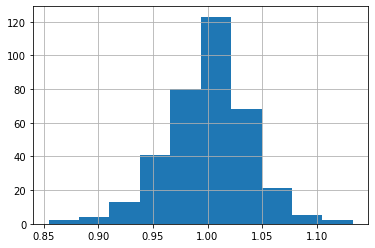

In [24]:
positive_carry_test["y"].hist()

Negative Carry Test

In [25]:
negative_carry_test = backtest_data[(backtest_data["Carry Rank"] <= 1/3)].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [26]:
negative_carry_test["x"] = negative_carry_test["Year"] + (negative_carry_test["Month"] - 1) / 12

In [27]:
negative_carry_test[["x", "y"]]

,x,y
0,1992.083333,0.999899
1,1992.166667,0.992977
2,1992.250000,0.986872
3,1992.333333,1.044906
4,1992.416667,1.010671
...,...,...
354,2021.583333,0.980413
355,2021.666667,1.041894
356,2021.750000,1.005262
357,2021.833333,0.955206


In [28]:
negative_carry_test["y_cum"] = negative_carry_test["y"].cumprod()

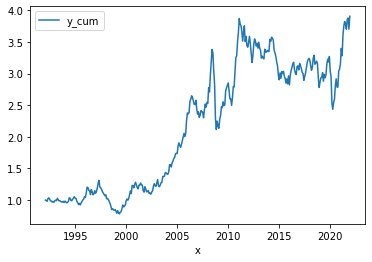

In [29]:
negative_carry_test.plot.line(x="x", y="y_cum")

In [30]:
negative_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.004552
std,0.038693
min,0.810273
25%,0.979342
50%,1.000795
75%,1.027921
max,1.117043


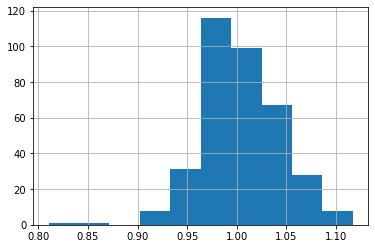

In [31]:
negative_carry_test["y"].hist()

Combined Carry Test

In [32]:
combined_carry_test = positive_carry_test[["x", "y"]].merge(negative_carry_test[["x", "y"]], on="x")

In [33]:
combined_carry_test["y"] = (2 - combined_carry_test["y_x"] + combined_carry_test["y_y"]) / 2

In [34]:
combined_carry_test[["x", "y"]]

,x,y
0,1992.083333,1.014669
1,1992.166667,0.992478
2,1992.250000,1.004614
3,1992.333333,1.018953
4,1992.416667,1.007861
...,...,...
354,2021.583333,0.967389
355,2021.666667,1.033791
356,2021.750000,0.989269
357,2021.833333,0.973071


In [35]:
combined_carry_test["y_cum"] = combined_carry_test["y"].cumprod()

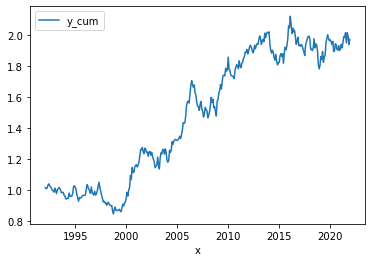

In [36]:
combined_carry_test.plot.line(x="x", y="y_cum")

In [37]:
combined_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.002109
std,0.020715
min,0.952460
25%,0.988149
50%,1.000918
75%,1.014523
max,1.075004


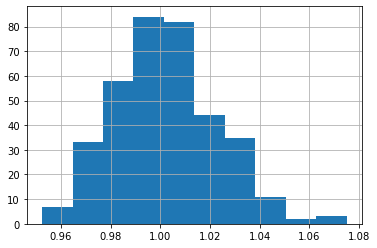

In [38]:
combined_carry_test["y"].hist()

All Carry Test

In [39]:
all_carry_test = backtest_data.groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [40]:
all_carry_test["x"] = all_carry_test["Year"] + (all_carry_test["Month"] - 1) / 12

In [41]:
all_carry_test[["x", "y"]]

,x,y
0,1992.083333,0.987582
1,1992.166667,1.002805
2,1992.250000,0.995651
3,1992.333333,1.024674
4,1992.416667,1.006917
...,...,...
354,2021.583333,1.005498
355,2021.666667,1.007544
356,2021.750000,1.011736
357,2021.833333,0.993376


In [42]:
all_carry_test["y_cum"] = all_carry_test["y"].cumprod()

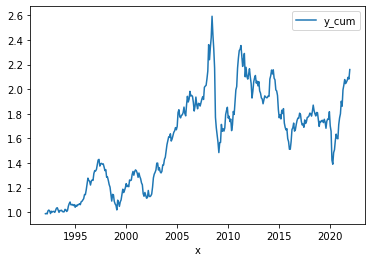

In [43]:
all_carry_test.plot.line(x="x", y="y_cum")

In [44]:
all_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.002644
std,0.031359
min,0.815559
25%,0.983788
50%,1.004036
75%,1.019773
max,1.100172


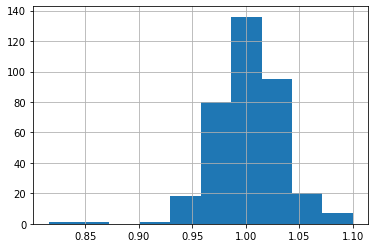

In [45]:
all_carry_test["y"].hist()

Look into the different percentiles and their return characteristics

In [46]:
backtest_data["Carry Rank Group"] = backtest_data["Carry Rank"].apply(lambda x: math.floor(x*10))

In [47]:
backtest_data.groupby("Carry Rank Group").agg(
    mean_return = ("c2_adj_monthly_return", "mean"),
    med_return = ("c2_adj_monthly_return", "mean"),
    min_return = ("c2_adj_monthly_return", "min"),
    max_return = ("c2_adj_monthly_return", "max"),
    std_return = ("c2_adj_monthly_return", "std")
)

,mean_return,med_return,min_return,max_return,std_return
Carry Rank Group,,,,,
0,1.004735,1.004735,0.720833,1.366957,0.076305
1,0.999690,0.999690,0.567803,1.318148,0.069514
2,1.007671,1.007671,0.625466,1.550507,0.073216
3,1.003439,1.003439,0.661273,1.313360,0.066612
4,1.002385,1.002385,0.697743,1.245527,0.066178
5,1.002838,1.002838,0.715061,1.372080,0.067180
6,1.005883,1.005883,0.449966,1.343601,0.071636
7,1.002845,1.002845,0.740697,1.367135,0.072925
8,0.997234,0.997234,0.794677,1.416961,0.068949


## Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [48]:
backtest_data["Momentum Rank"] = backtest_data.groupby(["Year", "Month"])["c2_momentum_signal"].rank("average", ascending=True,pct=True)

In [49]:
backtest_data[backtest_data["Momentum Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

105.94537926197928

In [50]:
backtest_data[backtest_data["Momentum Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

-0.9976059912590357

Positive Momentum Test

In [51]:
positive_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [52]:
positive_momentum_test["x"] = positive_momentum_test["Year"] + (positive_momentum_test["Month"] - 1) / 12

In [53]:
positive_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.010219
1,1992.166667,1.025362
2,1992.250000,1.037839
3,1992.333333,1.050081
4,1992.416667,0.994365
...,...,...
354,2021.583333,1.008072
355,2021.666667,0.993822
356,2021.750000,0.998075
357,2021.833333,0.983189


In [54]:
positive_momentum_test["y_cum"] = positive_momentum_test["y"].cumprod()

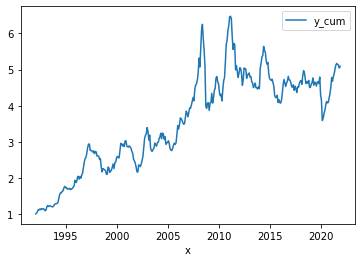

In [55]:
positive_momentum_test.plot.line(x="x", y="y_cum")

In [56]:
positive_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.005339
std,0.039713
min,0.780822
25%,0.982189
50%,1.006472
75%,1.028287
max,1.124378


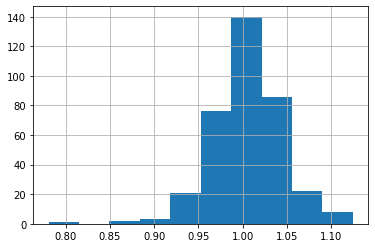

In [57]:
positive_momentum_test["y"].hist()

Negative Momentum Test

In [58]:
negative_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] <= 1/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [59]:
negative_momentum_test["x"] = negative_momentum_test["Year"] + (negative_momentum_test["Month"] - 1) / 12

In [60]:
negative_momentum_test[["x", "y"]]

,x,y
0,1992.083333,0.973414
1,1992.166667,0.995434
2,1992.250000,0.986067
3,1992.333333,1.006750
4,1992.416667,1.038265
...,...,...
354,2021.583333,0.991425
355,2021.666667,1.004757
356,2021.750000,1.021500
357,2021.833333,0.979919


In [61]:
negative_momentum_test["y_cum"] = (2 - negative_momentum_test["y"]).cumprod()

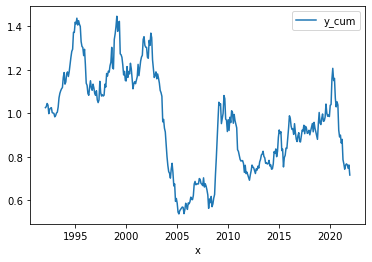

In [62]:
negative_momentum_test.plot.line(x="x", y="y_cum")

In [63]:
negative_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.000141
std,0.039645
min,0.854923
25%,0.976693
50%,1.001382
75%,1.022634
max,1.118405


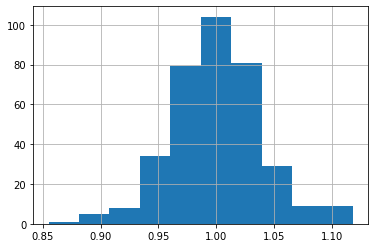

In [64]:
negative_momentum_test["y"].hist()

Combined Momentum Test

In [65]:
combined_momentum_test = negative_momentum_test[["x", "y"]].merge(positive_momentum_test[["x", "y"]], on="x")

In [66]:
combined_momentum_test["y"] = (2 - combined_momentum_test["y_x"] + combined_momentum_test["y_y"]) / 2

In [67]:
combined_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.018402
1,1992.166667,1.014964
2,1992.250000,1.025886
3,1992.333333,1.021665
4,1992.416667,0.978050
...,...,...
354,2021.583333,1.008323
355,2021.666667,0.994533
356,2021.750000,0.988287
357,2021.833333,1.001635


In [68]:
combined_momentum_test["y_cum"] = combined_momentum_test["y"].cumprod()

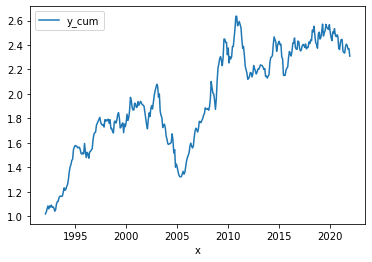

In [69]:
combined_momentum_test.plot.line(x="x", y="y_cum")

In [70]:
combined_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.002599
std,0.023099
min,0.907274
25%,0.990079
50%,1.002969
75%,1.015572
max,1.075163


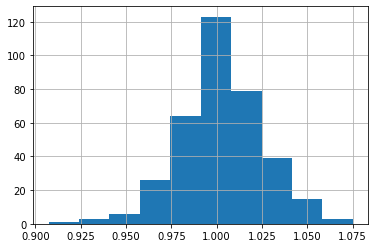

In [71]:
combined_momentum_test["y"].hist()

## Momentum-Carry Test

Positive Carry-Momentum Test

In [96]:
positive_carry_momentum_test = backtest_data[
    (backtest_data["Carry Rank"] >= 2/3) &
    (backtest_data["Momentum Rank"] <= 1/3)
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [97]:
positive_carry_momentum_test["x"] = positive_carry_momentum_test["Year"] + (positive_carry_momentum_test["Month"] - 1) / 12

In [98]:
positive_carry_momentum_test[["x", "y"]]

,x,y
0,1992.083333,0.969078
1,1992.166667,0.864368
2,1992.250000,1.007804
3,1992.333333,0.993140
4,1992.416667,1.046338
...,...,...
345,2021.500000,0.959081
346,2021.583333,1.046206
347,2021.750000,1.045396
348,2021.833333,0.969899


In [100]:
positive_carry_momentum_test["y_cum"] = (2 - positive_carry_momentum_test["y"]).cumprod()

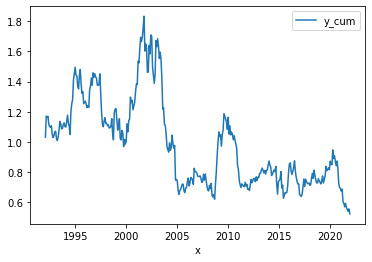

In [101]:
positive_carry_momentum_test.plot.line(x="x", y="y_cum")

In [103]:
positive_carry_momentum_test[["y"]].describe()

,y
count,350.000000
mean,1.000306
std,0.055616
min,0.822524
25%,0.968679
50%,1.003261
75%,1.031886
max,1.235845


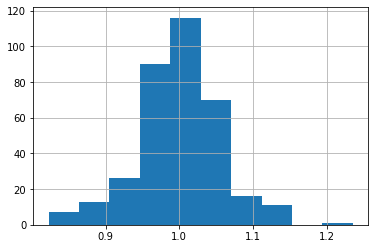

In [104]:
positive_carry_momentum_test["y"].hist()

Negative Carry-Momentum Test

In [88]:
negative_carry_momentum_test = backtest_data[
    (backtest_data["Carry Rank"] <= 1/3) &
    (backtest_data["Momentum Rank"] >= 2/3)
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [89]:
negative_carry_momentum_test["x"] = negative_carry_momentum_test["Year"] + (negative_carry_momentum_test["Month"] - 1) / 12

In [90]:
negative_carry_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.016308
1,1992.250000,1.024509
2,1992.333333,1.085359
3,1992.416667,0.950311
4,1992.500000,1.024539
...,...,...
346,2021.583333,1.002109
347,2021.666667,1.055939
348,2021.750000,1.001204
349,2021.833333,0.948781


In [91]:
negative_carry_momentum_test["y_cum"] = negative_carry_momentum_test["y"].cumprod()

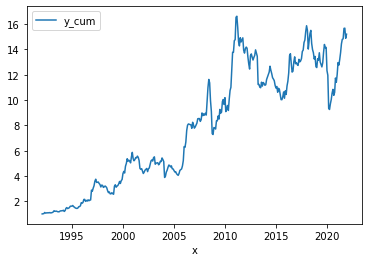

In [92]:
negative_carry_momentum_test.plot.line(x="x", y="y_cum")

In [93]:
negative_carry_momentum_test[["y"]].describe()

,y
count,351.000000
mean,1.009405
std,0.057458
min,0.756294
25%,0.976537
50%,1.009967
75%,1.038103
max,1.366957


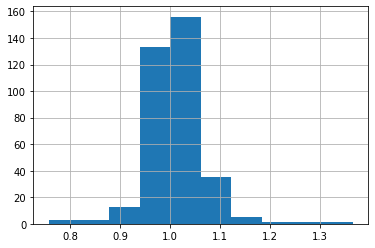

In [94]:
negative_carry_momentum_test["y"].hist()

Combined Carry Momentum Test

In [106]:
combined_carry_momentum_test = positive_carry_momentum_test[["x", "y"]].merge(negative_carry_momentum_test[["x", "y"]], on="x")

In [107]:
combined_carry_momentum_test["y"] = (2 - combined_carry_momentum_test["y_x"] + combined_carry_momentum_test["y_y"]) / 2

In [108]:
combined_carry_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.023615
1,1992.250000,1.008352
2,1992.333333,1.046110
3,1992.416667,0.951987
4,1992.500000,1.005994
...,...,...
337,2021.500000,1.033008
338,2021.583333,0.977951
339,2021.750000,0.977904
340,2021.833333,0.989441


In [109]:
combined_carry_momentum_test["y_cum"] = combined_carry_momentum_test["y"].cumprod()

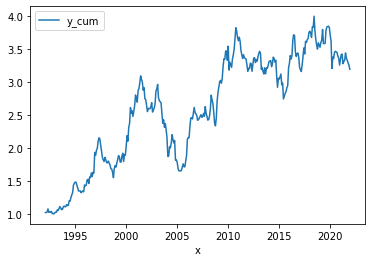

In [110]:
combined_carry_momentum_test.plot.line(x="x", y="y_cum")

In [111]:
combined_carry_momentum_test[["y"]].describe()

,y
count,342.000000
mean,1.004149
std,0.038791
min,0.858338
25%,0.981038
50%,1.002631
75%,1.025895
max,1.191457


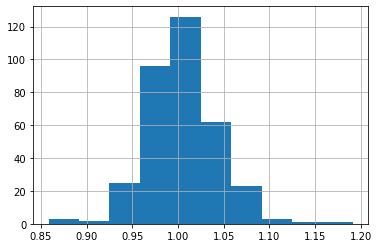

In [112]:
combined_carry_momentum_test["y"].hist()

# Output Plots

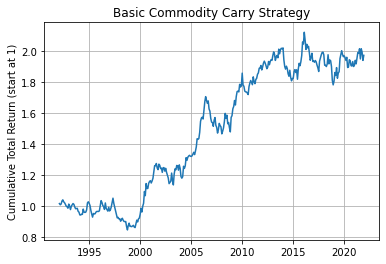

In [114]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(combined_carry_test["x"], combined_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Carry Strategy')

ax.grid()

fig.savefig("basic_carry_cum_return.png")
plt.show()

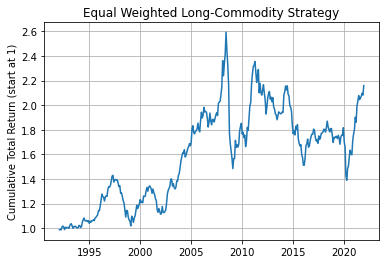

In [115]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(all_carry_test["x"], all_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Equal Weighted Long-Commodity Strategy')

ax.grid()

fig.savefig("ew_long_commodity_cum_return.png")
plt.show()

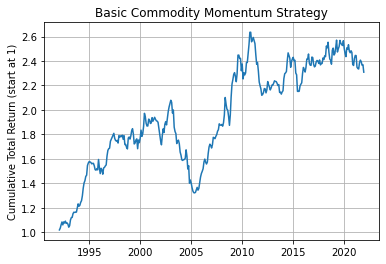

In [117]:
fig, ax = plt.subplots()
ax.plot(combined_momentum_test["x"], combined_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Momentum Strategy')

ax.grid()

fig.savefig("basic_momentum_cum_return.png")
plt.show()

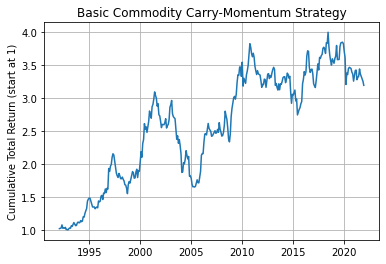

In [119]:
fig, ax = plt.subplots()
ax.plot(combined_carry_momentum_test["x"], combined_carry_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Carry-Momentum Strategy')

ax.grid()

fig.savefig("basic_carry_momentum_cum_return.png")
plt.show()